# A Basic Disease Association Analysis Using the UKB Accelerometer Data

 ## Introduction
In this notebook, we will associate overall activity levels with risk of incident cardiovascular disease.

## How to run this notebook
This notebook should be run in a *JupyterLab* session, with R as the kernel. It does *not* require a Spark cluster. See how to set it up [here](https://dnanexus.gitbook.io/uk-biobank-rap/working-on-the-research-analysis-platform/using-jupyterlab-on-the-research-analysis-platform).

The same conventions are followed as in notebook 2 (the first R notebook).

As in the earlier notebooks, this notebook is a demo, not an indicator of best practice. Analytic decisions here (e.g. which variables are adjusted for) are based on the papers we replicate, and should not be interpreted as prescriptive. Analytic decisions should be made afresh in the context of each new analysis.

## Set up the session

We load packages:

In [1]:
# First we need to install packages that aren't already present
pkgs <- c("data.table", "ggplot2", "survival", "table1", "IRdisplay", "dplyr") # packages we need
pkgs_inst <- pkgs[!{pkgs %in% rownames(installed.packages())}] # check which are not present 
install.packages(pkgs_inst, repos = "https://www.stats.bris.ac.uk/R/")

# Load packages
lapply(pkgs, library, character.only = TRUE)
# using lapply just allows us to load several packages on one line

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Formula’



Attaching package: ‘table1’


The following objects are masked from ‘package:base’:

    units, units<-



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[[1]]
[1] "data.table" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"      

[[2]]
[1] "ggplot2"    "data.table" "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"      

[[3]]
 [1] "survival"   "ggplot2"    "data.table" "stats"      "graphics"  
 [6] "grDevices"  "utils"      "datasets"   "methods"    "base"      

[[4]]
 [1] "table1"     "survival"   "ggplot2"    "data.table" "stats"     
 [6] "graphics"   "grDevices"  "utils"      "datasets"   "methods"   
[11] "base"      

[[5]]
 [1] "IRdisplay"  "table1"     "survival"   "ggplot2"    "data.table"
 [6] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[11] "methods"    "base"      

[[6]]
 [1] "dplyr"      "IRdisplay"  "table1"     "survival"   "ggplot2"   
 [6] "data.table" "stats"      "graphics"   "grDevices"  "utils"     
[11] "datasets"   "methods"    "base"

We load the data we prepared earlier (noting again that the code is different depending on whether you're running it in the same session as the earlier scripts, or have come back to do this later): 

In [2]:
dat <- fread("prepped_data.csv", data.table = FALSE) # version if running in same session as notebook 2
#dat <- fread("/mnt/project/Accelerometry_RAP_Demo/prepped_data.csv", data.table = FALSE) # version if running in different session

## Summarise and prepare the data

We summarise to understand the data structure:

In [3]:
# summary(dat) # uncomment to run, avoiding printing lots of information on internet

We create factors and make sure they have sensible ordering of levels (e.g. large-ish reference category): 

In [4]:
dat$ethnicity <- factor(dat$ethnicity, levels = c("White", "Nonwhite"))
dat$tdi_quarters <- factor(dat$tdi_quarters, levels = c("Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"))
dat$smoking <- factor(dat$smoking, levels = c("Never", "Previous", "Current"))
dat$alcohol <- factor(dat$alcohol, levels = c("<3 times/week", "3+ times/week", "Never"))
dat$overall_activity_quarters <- factor(dat$overall_activity_quarters, levels = c("Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"))

##  Describe and explore the data

We've explored the accelerometer data in a previous notebook, so here we'll focus on how the accelerometer covaries with the participant characteristics we're most interested in. 

We use the 'table1' package to 'cheat' and generate a nicely formatted table:

In [5]:
# Add labels
label(dat$age_entry_years)   <- "Age at accelerometer wear"
label(dat$overall_activity_quarters) <- "Quarter of overall activity"
label(dat$sex) <- "Sex"
label(dat$ethnicity) <- "Ethnicity"
label(dat$tdi_quarters) <- "Quarter of Townsend Deprivation Index"
label(dat$age_education) <- "Age completed full-time education"
label(dat$smoking) <- "Smoking status"
label(dat$alcohol) <- "Frequency of alcohol consumption"
label(dat$BMI) <- "BMI"
units(dat$age_entry_years) <- "years"
units(dat$overall_activity_quarters) <- "mg"

# We'll customise how we render variables so rather than median (min, max) we present median (Q1, Q3)
my_render_cont <- function(x){
  with(
    stats.apply.rounding(stats.default(x)),
    c(
      "",
      `Mean (SD)` = sprintf("%s (%s)", MEAN, SD),
      `Median [Q1, Q3]` = sprintf("%s [%s, %s]",
                                    MEDIAN, Q1, Q3)
    )
  )
}

# Make table
tab_desc <- table1::table1(~ age_entry_years + sex + ethnicity + tdi_quarters + age_education + smoking + alcohol + BMI | overall_activity_quarters, 
                           data = dat, 
                           render.cont = my_render_cont) 
IRdisplay::display_html(tab_desc) # Show table
write(tab_desc, "descriptive_table.html")

,Quarter 1(N=22051),Quarter 2(N=22006),Quarter 3(N=22095),Quarter 4(N=22059),Overall(N=88211)
Age at accelerometer wear (years),,,,,
Mean (SD),64.6 (7.39),62.7 (7.66),61.3 (7.71),59.4 (7.62),62.0 (7.83)
"Median [Q1, Q3]","66.1 [59.7, 70.3]","63.9 [57.0, 68.7]","62.1 [55.2, 67.5]","59.4 [52.9, 65.6]","63.0 [55.9, 68.2]"
Sex,,,,,
Female,11657 (52.9%),12934 (58.8%),13356 (60.4%),13287 (60.2%),51234 (58.1%)
Male,10394 (47.1%),9072 (41.2%),8739 (39.6%),8772 (39.8%),36977 (41.9%)
Ethnicity,,,,,
White,21521 (97.6%),21381 (97.2%),21391 (96.8%),21237 (96.3%),85530 (97.0%)
Nonwhite,530 (2.4%),625 (2.8%),704 (3.2%),822 (3.7%),2681 (3.0%)
Quarter of Townsend Deprivation Index,,,,,


There's much more we could do here, but for now we will move on to analysing the association of overall activity with risk of incident cardiovascular disease. 

## Associations with risk of incident cardiovascular disease 

In the data preparation step, we added an event status indicator at exit and a follow-up time variable. Using these, we can run a Cox model to associate overall activity with risk of incident cardiovascular disease. We'll start by using time-on-study as the timescale and set it up using the 'survival' package in R. We'll also adjust for various possible confounding variables (following the confounders used by [Ramakrishnan et al.](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003487)):

In [6]:
cox_model <- coxph(
                Surv(fu_time, ind_inc_cvd) ~ overall_activity_quarters + age_entry_years + sex + ethnicity + tdi_quarters + age_education + smoking + alcohol,
                data = dat
                )
# This line uses functions from the 'survival' package

Alternatively, we could analyse the data using [age as the timescale](https://journals.lww.com/epidem/Fulltext/2012/07000/Proportional_Hazards_Regression_in_Epidemiologic.9.aspx) (rather than time on study): 

In [7]:
cox_model_age_timescale <- coxph(
                            Surv(age_entry_days, age_exit_days, ind_inc_cvd) ~ overall_activity_quarters + sex + ethnicity + tdi_quarters + age_education + smoking + alcohol,
                            data = dat
                               )

We can now look at modelling assumptions, which we'll do using the first model above. A key assumption of Cox regression is the **proportional hazards assumption**. There are several ways to assess this. One way is through plots and a statistical test of the Schoenfeld residuals. Read more [here](http://www.sthda.com/english/wiki/cox-model-assumptions). Other ways include use of log-log survival plots or considering interaction terms between the variable of interest and time.  

                            chisq df       p
overall_activity_quarters  7.6062  3 0.05489
age_entry_years            0.9248  1 0.33622
sex                       11.3228  1 0.00077
ethnicity                  0.2394  1 0.62462
tdi_quarters               0.6947  3 0.87445
age_education              0.0961  1 0.75662
smoking                    2.5108  2 0.28496
alcohol                    1.1072  2 0.57489
GLOBAL                    26.5451 14 0.02205

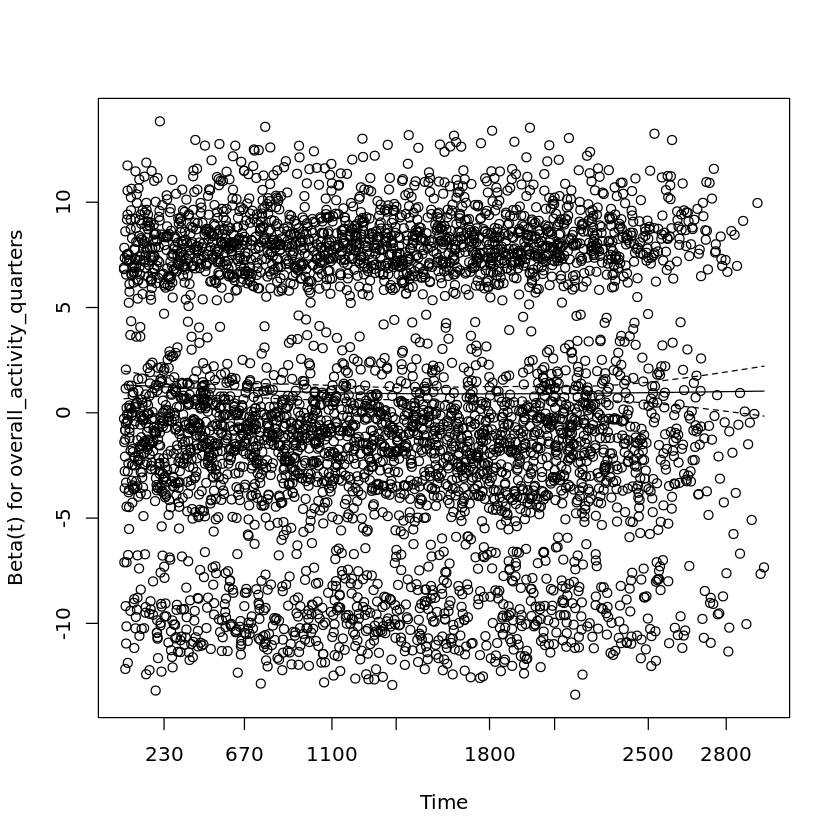

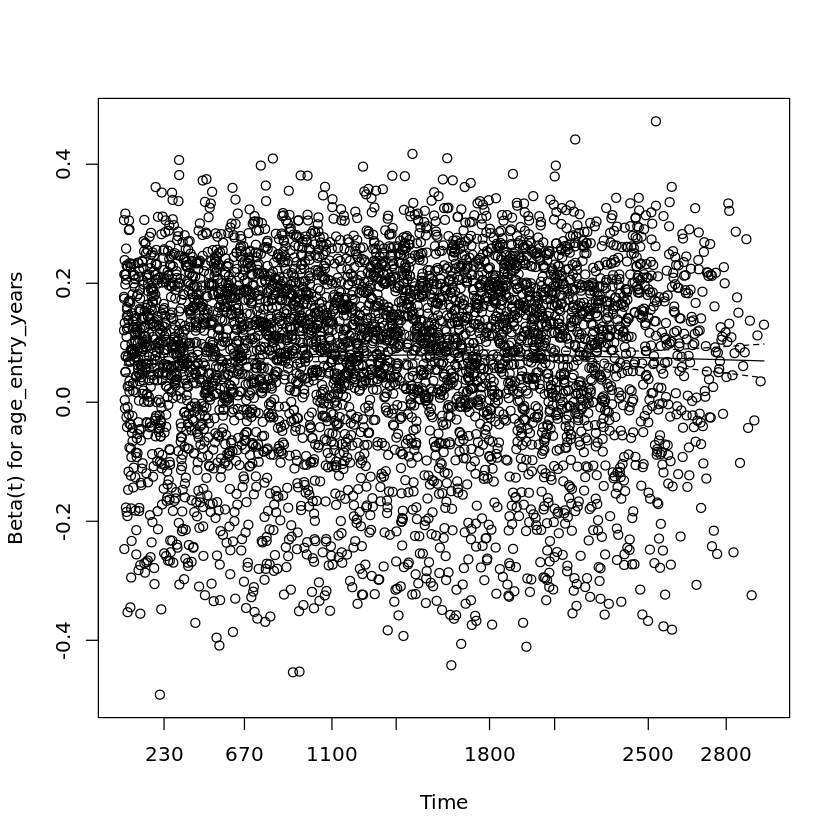

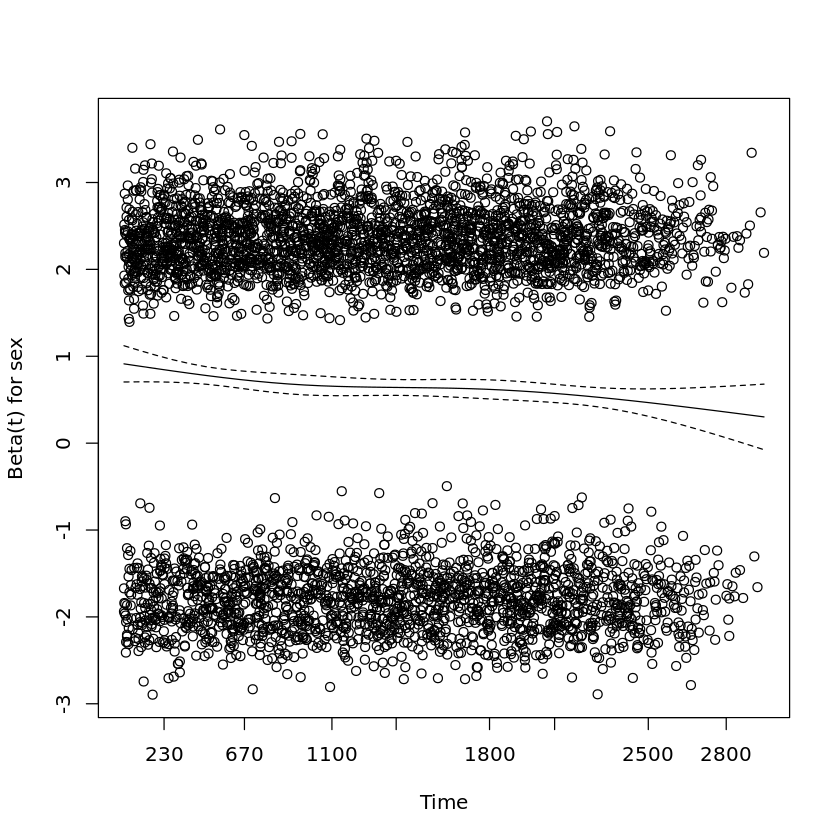

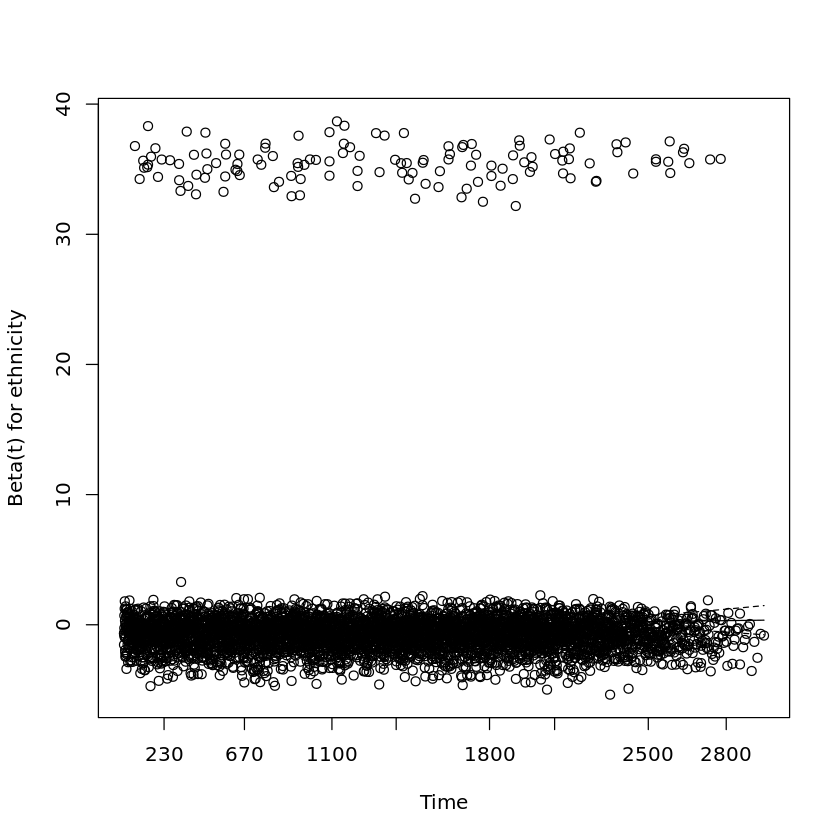

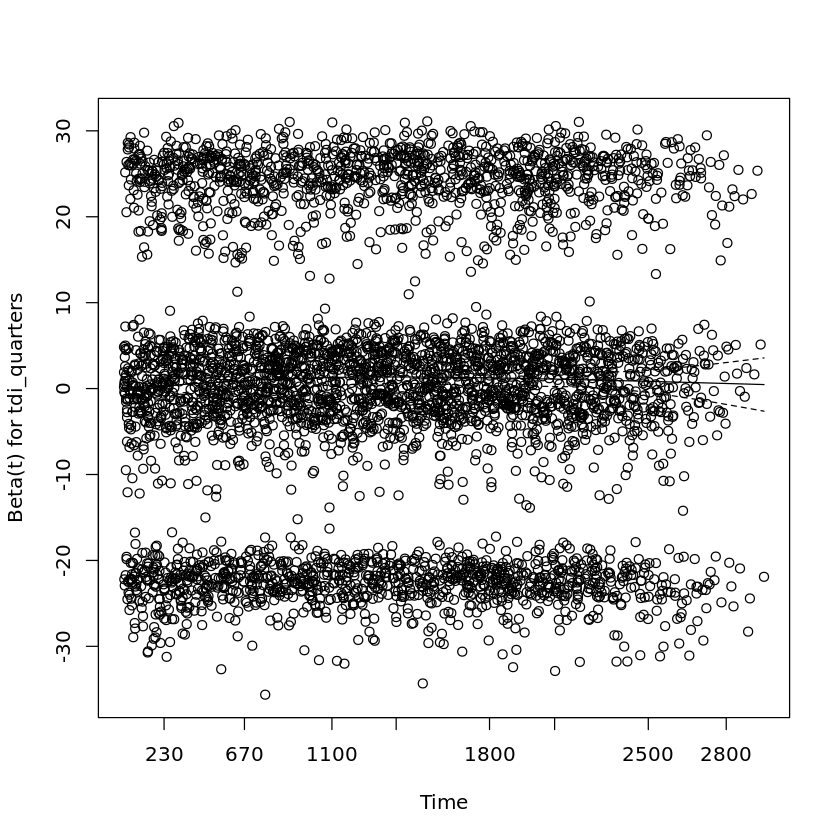

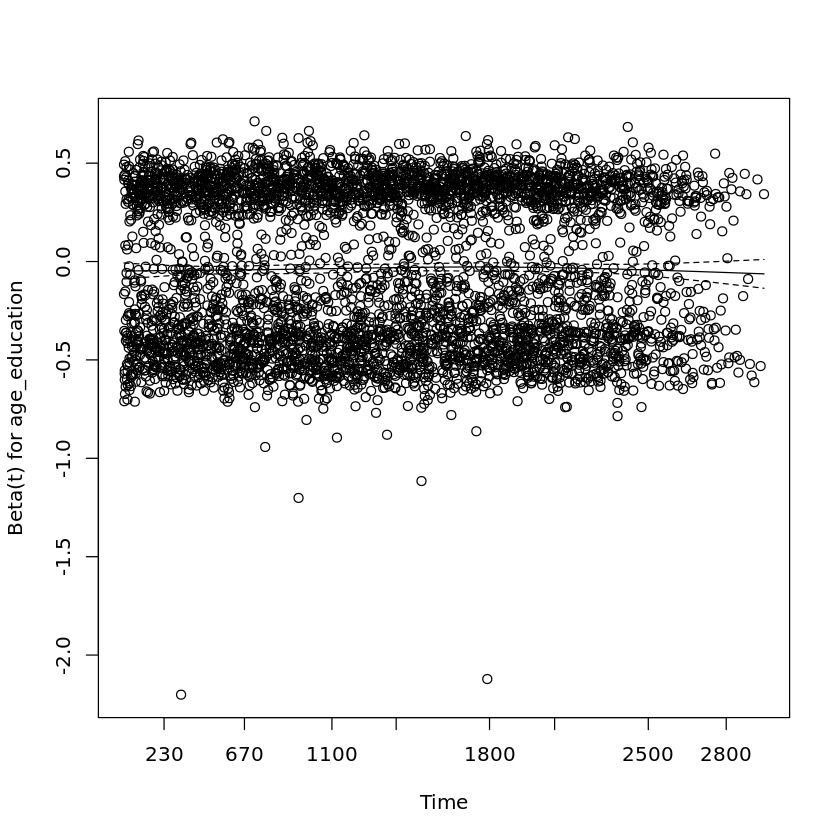

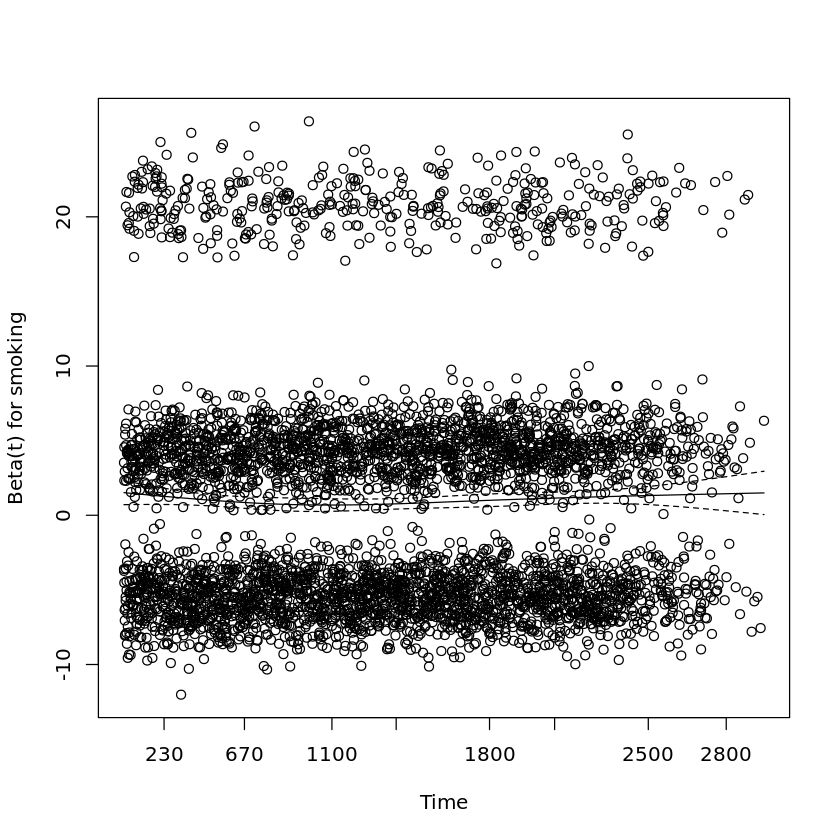

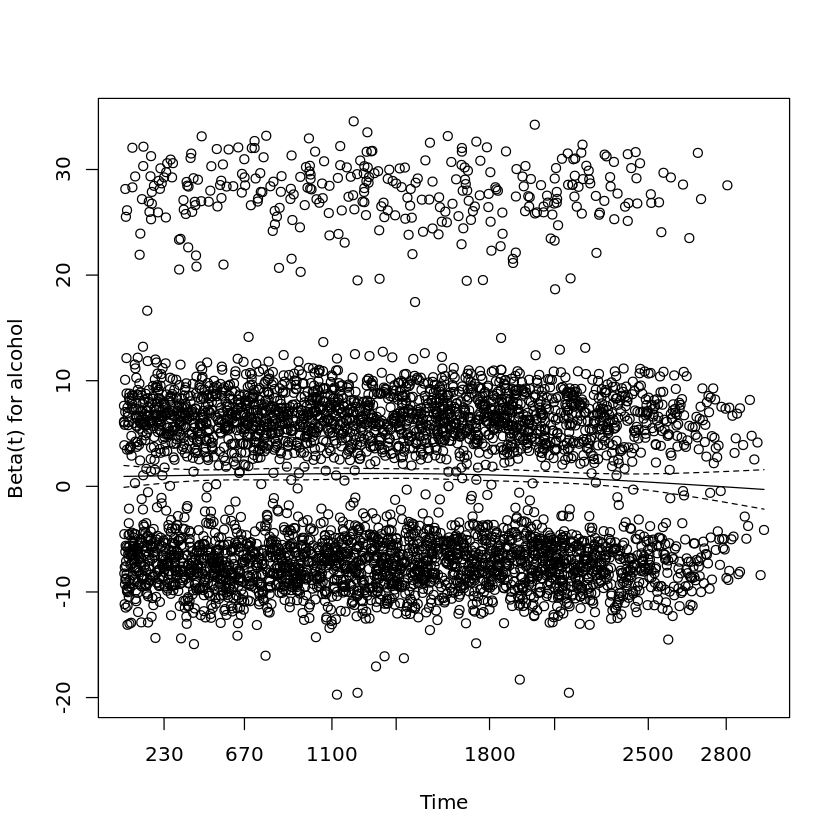

In [8]:
cox.zph(cox_model)
plot(cox.zph(cox_model))

It's sometimes hard to judge how important violations of the proportional hazards assumptions are. As the statistical tests just assess evidence against proportionality, they may detect even very modest non-proportionality, particularly if there is a lot of data. Therefore, it's helpful to use graphical methods or a quantitive assessment of the interaction with time as well. 

In this data, it looks like there's reasonable evidence that sex violates the proportional hazards assumption: this can be seen both from the very small p-value of the statistical test and from the trend in the plot of the Schoenfeld residuals for sex. This is something we could address, for example by stratifying on sex: 

In [9]:
cox_model_strat <- coxph(
                        Surv(fu_time, ind_inc_cvd) ~ overall_activity_quarters + age_entry_years + strata(sex) + ethnicity + tdi_quarters + age_education + smoking + alcohol,
                        data = dat
                        )
cox.zph(cox_model_strat)

                           chisq df     p
overall_activity_quarters  7.462  3 0.059
age_entry_years            1.354  1 0.245
ethnicity                  0.271  1 0.603
tdi_quarters               0.639  3 0.888
age_education              0.153  1 0.696
smoking                    3.229  2 0.199
alcohol                    2.457  2 0.293
GLOBAL                    15.171 13 0.297

Note that in a Cox model, stratification has a particular meaning: one model is still calculated using data from all participants, but when estimating the model participants are only compared with participants in the same strata (in this case, with other participants of the same sex). Most textbooks covering Cox regression will cover this.

We look at the model summary: 

In [10]:
summary(cox_model_strat)

Call:
coxph(formula = Surv(fu_time, ind_inc_cvd) ~ overall_activity_quarters + 
    age_entry_years + strata(sex) + ethnicity + tdi_quarters + 
    age_education + smoking + alcohol, data = dat)

  n= 88211, number of events= 4555 

                                        coef exp(coef)  se(coef)      z
overall_activity_quartersQuarter 2 -0.205944  0.813879  0.038378 -5.366
overall_activity_quartersQuarter 3 -0.275319  0.759330  0.040850 -6.740
overall_activity_quartersQuarter 4 -0.444139  0.641376  0.045760 -9.706
age_entry_years                     0.075034  1.077921  0.002336 32.122
ethnicityNonwhite                   0.240178  1.271476  0.091290  2.631
tdi_quartersQuarter 2               0.090431  1.094646  0.042179  2.144
tdi_quartersQuarter 3               0.071830  1.074472  0.042786  1.679
tdi_quartersQuarter 4               0.168538  1.183573  0.042842  3.934
age_education                      -0.036885  0.963787  0.005980 -6.168
smokingPrevious                     0.165302  1

The `exp(coef)` column gives the hazard ratio and the lower .95 and upper .95 columns its confidence interval. 

## Presenting results

We could plot the results. First we extract and format them: 

In [11]:
# Extract details from model
plot_dat <- as.data.frame(
  exp(cbind(coef(cox_model_strat), confint(cox_model_strat)))
)
colnames(plot_dat) <- c("HR", "lower_CI", "upper_CI")
plot_dat$var_name <- rownames(plot_dat)
plot_dat$var_name <- sub("overall_activity_quarters", "", plot_dat$var_name)

# Restrict to only activity variables and add row for the reference
plot_dat <- plot_dat[1:3, ]
ref_row <-
  data.frame(
    "var_name" = levels(dat$overall_activity_quarters)[1], 
    "HR" = 1,
    "lower_CI" = 1,
    "upper_CI"  = 1
  )
plot_dat <- rbind(ref_row, plot_dat)

# Add event numbers
plot_dat$event_number <- sapply(
    X = as.factor(plot_dat$var_name),
    FUN = function(x) sum(dat$ind_inc_cvd[dat$overall_activity_quarters == x])
  ) 

# Add label columns 
round_2_dp <- function(x) format(round(x, digits = 2), nsmall = 2) # this line just writes a utility function to round to 2 dp
plot_dat$label_HR <- paste0(round_2_dp(plot_dat$HR), " (", round_2_dp(plot_dat$lower_CI), ", ", round_2_dp(plot_dat$upper_CI), ")")
plot_dat$label_quarter <- c("Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4")
plot_dat$label_events <- plot_dat$event_number

# Add a title row
title_row <-
  data.frame(
    "var_name" = " ", 
    "HR" = NA,
    "lower_CI" = NA,
    "upper_CI"  = NA, 
    "event_number" = NA, 
    "label_quarter" = "Group",
    "label_HR" = "HR (95% CI)", 
    "label_events" = "Events"
  )

plot_dat <- rbind(title_row, plot_dat)
plot_dat$var_name <- factor(plot_dat$var_name, levels = c(" ", levels(dat$overall_activity_quarters)))

We can then create a plot:

Warning message:
“Removed 1 rows containing missing values (geom_point).”


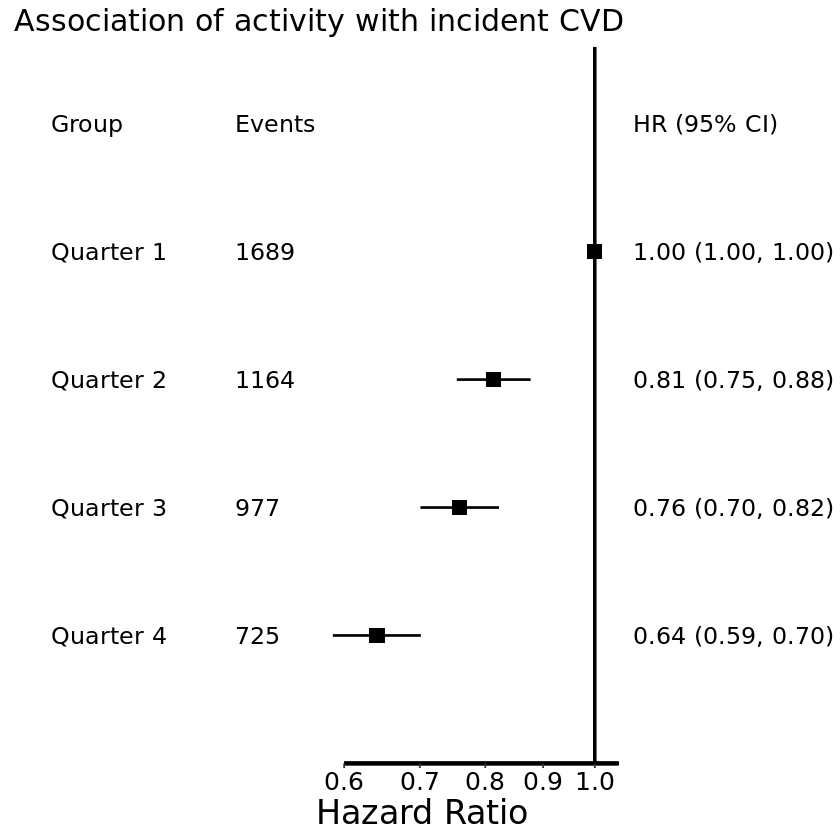

In [12]:
overall_activity_cox_plot <- ggplot(plot_dat, aes(x = HR, y = var_name)) + # SET UP PLOT DATA 
  
  # AXES: SCALES AND LABELS
  scale_x_continuous(trans = "log", breaks = seq(0.6, 1.0, by = 0.1)) + 
  scale_y_discrete(limits = rev) +
  labs(title = "Association of activity with incident CVD", x = "Hazard Ratio") +

  # LINES: VERTICAL LINE AT 1 AND X AXIS
  geom_vline(aes(xintercept = 1),
             size = 1) +
  geom_segment(aes(x = 0.6, xend = 1.05, y = 0, yend = 0), colour = "black", size = 1) + # Using this segment to colour axis so we can have a longer invisible axis to position text

  # ADD PLOT DATA
  geom_errorbar(aes(xmin = lower_CI, xmax = upper_CI), width = 0, size = 0.75) +
  geom_point(size = 4, shape = 15) +
  
  # ADD LABELS TO PLOT
  geom_text(aes(x = 0.33, label = label_quarter), hjust = 0, size = 5) +
  geom_text(aes(label = label_events, x = 0.48), hjust = 0, size = 5) +
  geom_text(aes(label = label_HR, x = 1.08), hjust = 0, size = 5) +

  # THEME (NON-DATA ELEMENTS OF PLOT)
  theme_classic()  + 
  theme(axis.line.y = element_blank(), 
        axis.line.x = element_blank(),
        axis.text.x = element_text(size = 15, colour = "black"), 
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.x = element_text(size = 20), 
        axis.title.y = element_blank(), 
        title = element_text(size = 15), 
        legend.position = "none") + 

    # CANVAS
    coord_cartesian(xlim = c(0.33, 1.5), clip = "off")

# Display plot 
overall_activity_cox_plot

We could edit this plot to make it visually nicer, but for now we write it out to save it:

In [13]:
svg("overall_activity_cox_plot.svg")
print(overall_activity_cox_plot)
dev.off()

Warning message:
“Removed 1 rows containing missing values (geom_point).”


png 
  2

## Additional and sensitivity analyses

There are many additional or sensitivity analyses we could use to better understand these results. 

When working with physical activity, adiposity/ body size is an important consideration. Adiposity may *mediate* associations between physical activity and CVD, and so we did not adjust for it in our main analysis. However, adiposity may also act as a confounder, in which case we would want to adjust for it.

An analysis adjusting for Body Mass Index (BMI) may help to explore its role a little further:


                           chisq df     p
overall_activity_quarters  7.581  3 0.056
age_entry_years            1.311  1 0.252
ethnicity                  0.274  1 0.601
tdi_quarters               0.608  3 0.895
age_education              0.169  1 0.681
smoking                    3.317  2 0.190
alcohol                    2.479  2 0.290
BMI                        4.690  1 0.030
GLOBAL                    19.065 14 0.162

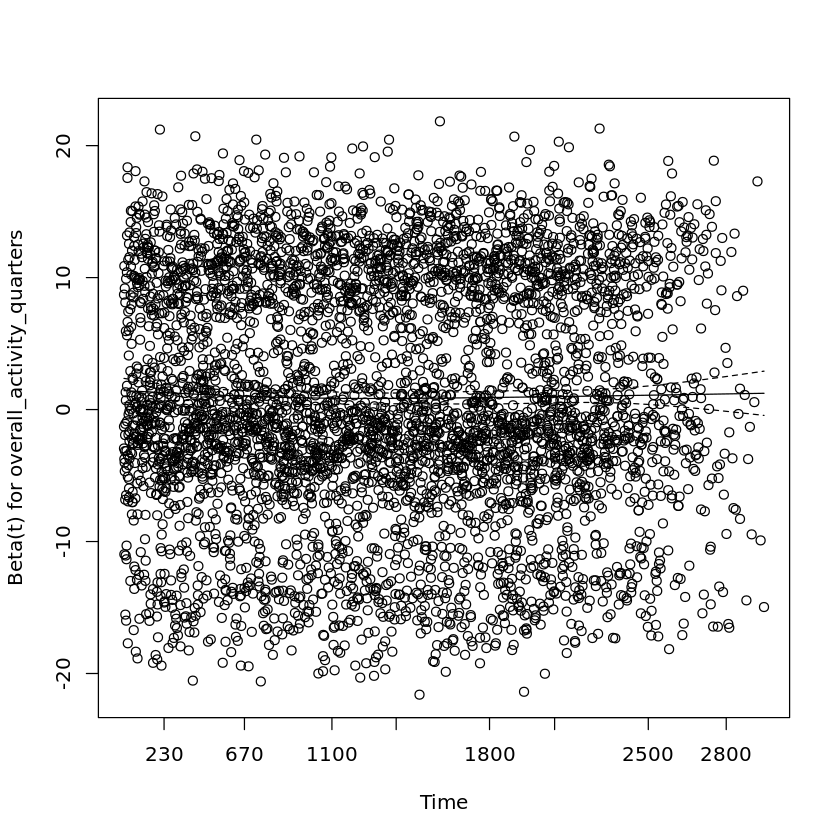

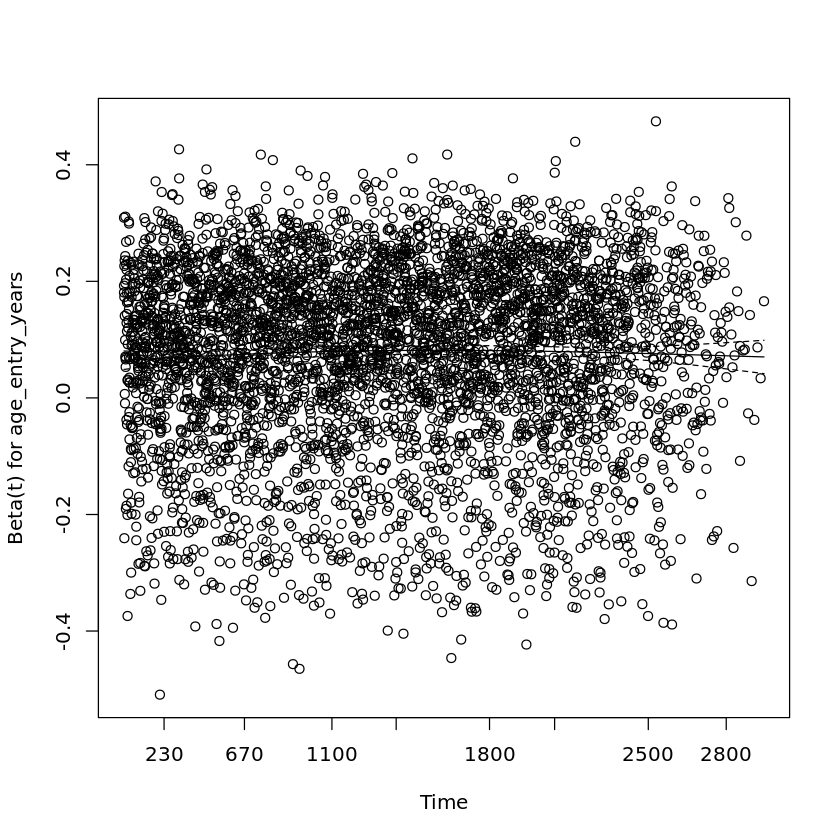

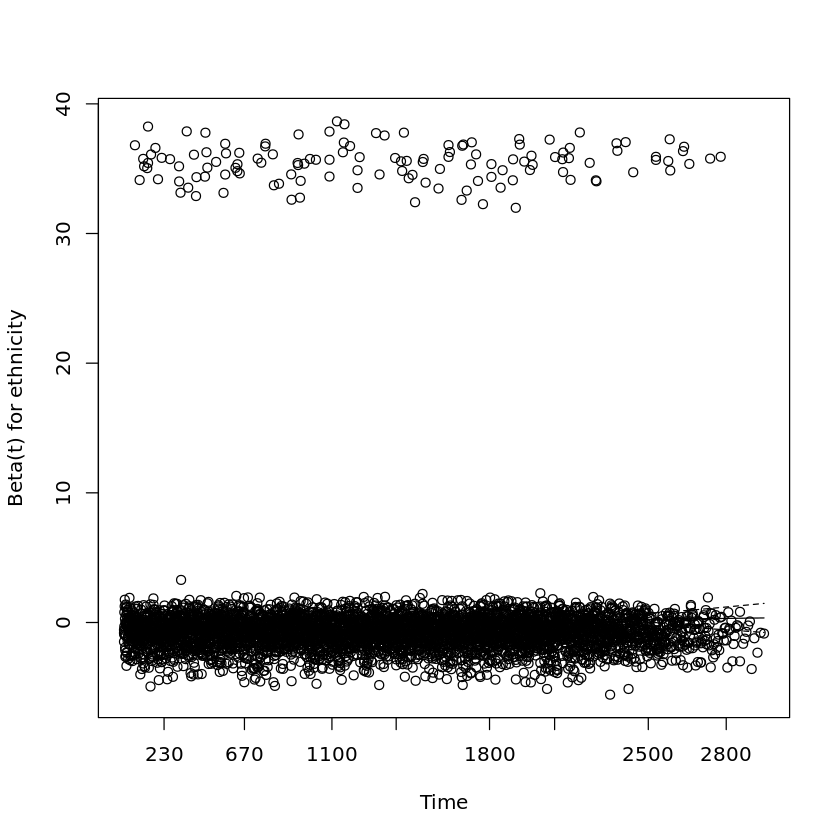

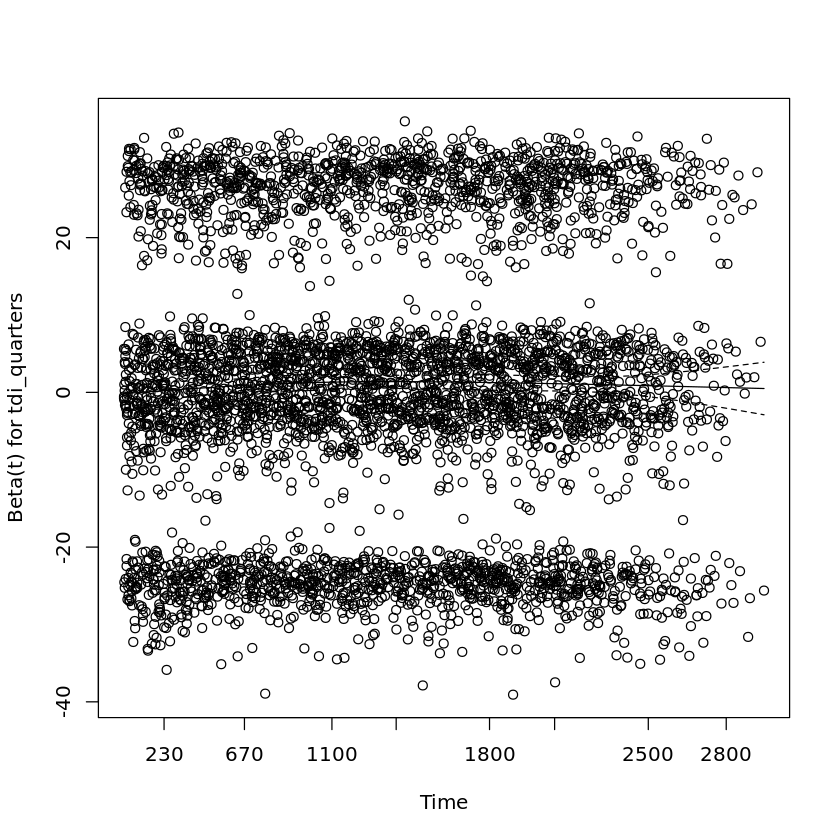

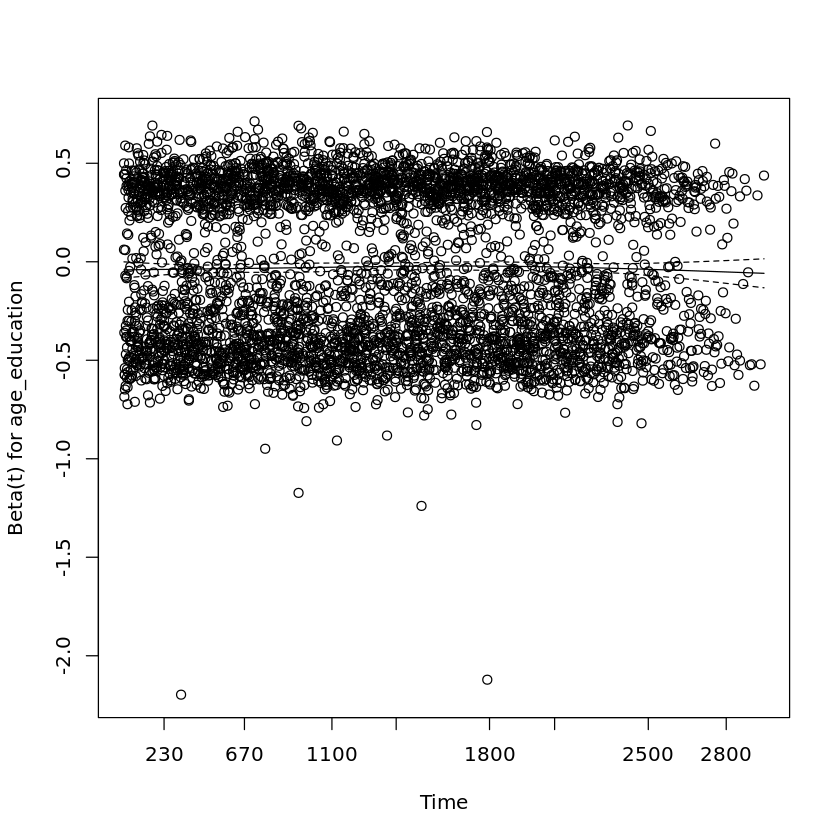

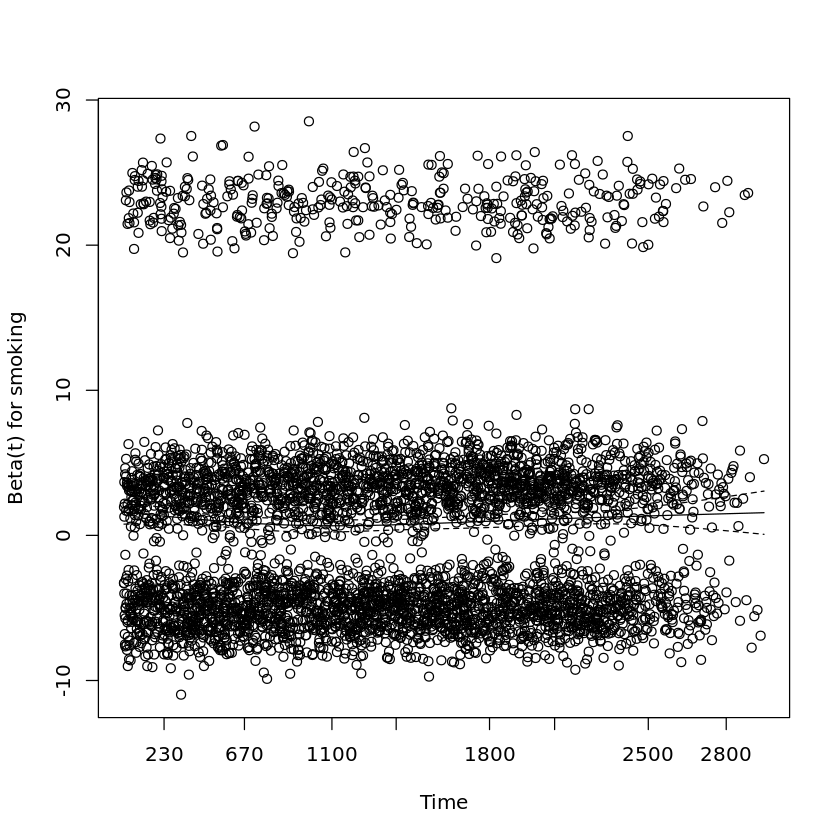

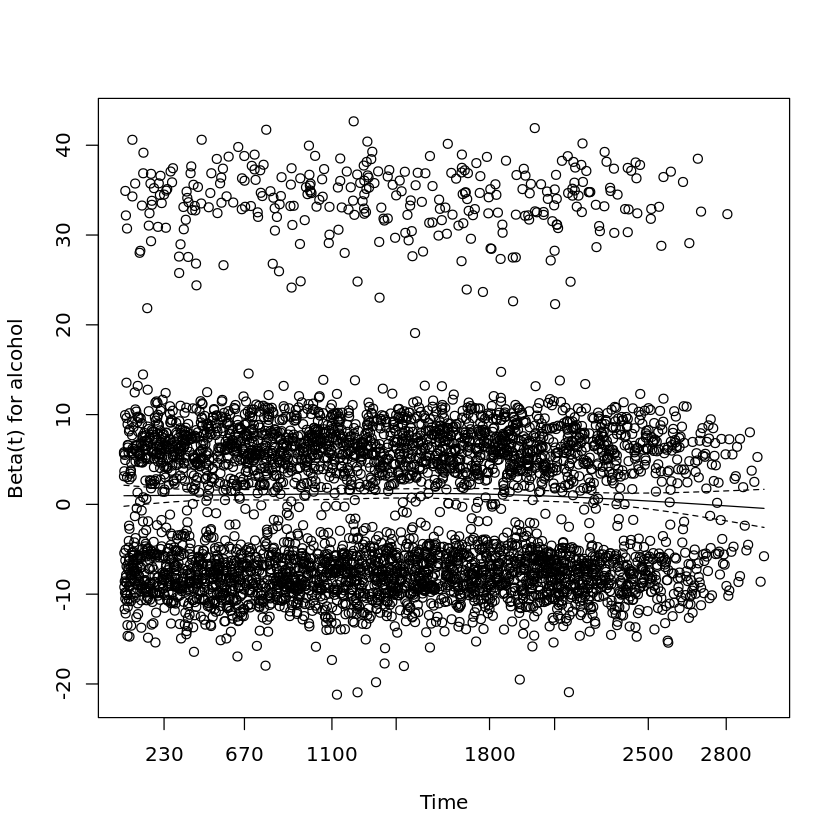

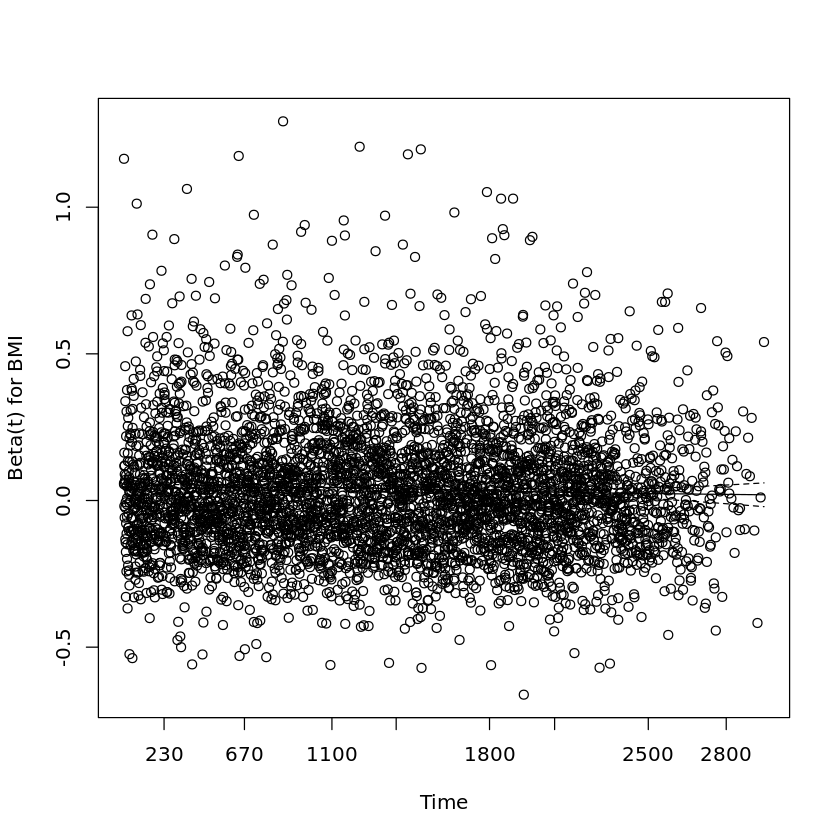

In [14]:
cox_model_strat_wbmi <- coxph(
                            Surv(fu_time, ind_inc_cvd) ~ overall_activity_quarters + age_entry_years + strata(sex) + ethnicity + tdi_quarters + age_education + smoking + alcohol + BMI,
                            data = dat
                            )
cox.zph(cox_model_strat_wbmi)
plot(cox.zph(cox_model_strat_wbmi))

We can compare the association seen in this model to that in our earlier model: 

In [15]:
# Without BMI adjustment
summary(cox_model_strat)$conf.int

# With BMI adjustment
summary(cox_model_strat_wbmi)$conf.int

,exp(coef),exp(-coef),lower .95,upper .95
overall_activity_quartersQuarter 2,0.8138790,1.2286838,0.7549056,0.8774595
overall_activity_quartersQuarter 3,0.7593298,1.3169507,0.7009040,0.8226260
overall_activity_quartersQuarter 4,0.6413760,1.5591477,0.5863563,0.7015585
age_entry_years,1.0779211,0.9277117,1.0729973,1.0828675
ethnicityNonwhite,1.2714760,0.7864875,1.0631675,1.5205989
tdi_quartersQuarter 2,1.0946462,0.9135372,1.0077923,1.1889852
tdi_quartersQuarter 3,1.0744724,0.9306893,0.9880434,1.1684619
tdi_quartersQuarter 4,1.1835728,0.8448995,1.0882477,1.2872479
age_education,0.9637872,1.0375734,0.9525567,0.9751502
smokingPrevious,1.1797490,0.8476379,1.1079687,1.2561796


,exp(coef),exp(-coef),lower .95,upper .95
overall_activity_quartersQuarter 2,0.8571504,1.1666564,0.7945204,0.9247174
overall_activity_quartersQuarter 3,0.8208128,1.2183046,0.7566166,0.8904558
overall_activity_quartersQuarter 4,0.7213122,1.3863622,0.6576481,0.7911394
age_entry_years,1.0801515,0.9257961,1.0751763,1.0851497
ethnicityNonwhite,1.2599790,0.7936641,1.0535558,1.5068466
tdi_quartersQuarter 2,1.0878526,0.9192422,1.0015265,1.1816195
tdi_quartersQuarter 3,1.0663502,0.9377782,0.9805521,1.1596556
tdi_quartersQuarter 4,1.1660164,0.8576209,1.0720375,1.2682338
age_education,0.9702654,1.0306458,0.9588982,0.9817674
smokingPrevious,1.1468220,0.8719749,1.0768385,1.2213536


We see that adjusting for BMI has partially attenuated the associations seen, suggesting they are partially explained by BMI (e.g. HR for quarter 4 vs quarter 1 of overall activity attenuated from 0.64 to 0.72). 

This is just one example of a useful and relevant additional analysis. Other examples can be found in the linked papers. 

## Uploading plots and tables

We shouldn't forget to upload the figures we've generated in this session. Again, this won't run in JupyterLab with an R kernel, but will run in a terminal running bash:

In [ ]:
%%bash
dx upload descriptive_table.html --dest Accelerometry_RAP_Demo/descriptive_table.html
dx upload overall_activity_cox_plot.svg --dest Accelerometry_RAP_Demo/overall_activity_cox_plot.svg